In [4]:
import numpy as np
import pandas as pd
import pickle,random
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score

### Pre-processing

In [2]:
def metadata_coverter(metadata) :
    converter = {}
    for idx,component in enumerate(sorted(metadata.unique())) :
        converter[component] = idx
    return converter

In [3]:
with open("/home/bruce1996/nvme2/scRNA/GSE149614_overall_normalized.pkl",'rb') as f :
    scRNA_exp_m = pickle.load(f)
f.close()

with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/ensembl2hgnc.pkl",'rb') as f :
    ens2hgsc = pickle.load(f)
f.close()
hgnc2ens = {}
for ens,hgnc in ens2hgsc.items() :
    if isinstance(hgnc,str) :
        hgnc2ens[hgnc] = ens
scRNA_metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
intersection = set(scRNA_exp_m.index).intersection(hgnc2ens.keys())
### subset expression matrix by coding gene & celltype
exp_m = scRNA_exp_m.loc[intersection,scRNA_metadata.index[np.where((scRNA_metadata['Celltype'] == 'Hepatocyte') & (scRNA_metadata['site']=='Tumor'),True,False)]]
exp_m.index = [hgnc2ens[x] for x in intersection]
metadata = scRNA_metadata.loc[exp_m.columns,:]
del scRNA_exp_m
### load vote information
vote = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))
non_voted_gene = list(set(set(vote.index) - set(voted_gene)).intersection(exp_m.index))

In [4]:
condition = 'patient'
stage_d = metadata_coverter(metadata[condition])
y_true = metadata.loc[exp_m.columns,condition].replace(stage_d).values

### UMAP + HBSCAN 

In [49]:
import hdbscan
import seaborn as sns
from umap import UMAP

In [5]:
seurat_hvg = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvg.txt",sep='\t',index_col=0)

In [40]:
candidate_gene = seurat_hvg['EnsID'][np.where(seurat_hvg['EnsID'] != 'Non-coding',True,False)]
hvg_df = exp_m.loc[candidate_gene,:]
reducer = UMAP(n_jobs=32,n_components=2)
embedding = reducer.fit_transform(hvg_df.T)

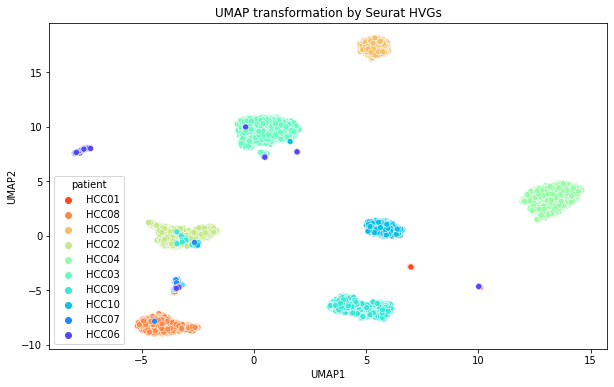

In [58]:
embedding_df = pd.DataFrame(embedding,index=exp_m.columns,columns=['UMAP1','UMAP2'])
embedding_df['virus'] = metadata.loc[embedding_df.index,'virus']
embedding_df['patient'] = metadata.loc[embedding_df.index,'patient']
embedding_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvg_umap_transformation_embedding.txt",sep='\t')

plt.figure(figsize=(10,6))
sns.scatterplot(data=embedding_df,x='UMAP1',y='UMAP2',hue='patient',palette='rainbow_r')
plt.title("UMAP transformation by Seurat HVGs")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_seurat/seurat_hvg_umap_transformation_patient.pdf",dpi=300,format='pdf')

In [16]:
def calculate_umap_clustering_result(exp_matrix,ground_truth) :
    """_summary_

    Args:
        exp_matrix (pd.DataFrame): input expression matrix 
        ground_truth (np.array): metadata of samples
    """    
    reducer = UMAP(n_jobs=32,n_components=30)
    embedding = reducer.fit_transform(exp_matrix)
    hdbscan_labels = hdbscan.HDBSCAN().fit_predict(embedding)


    metric_dict = {}
    metric_dict['ARI'] = adjusted_rand_score(ground_truth,hdbscan_labels)
    metric_dict['NMI'] = normalized_mutual_info_score(ground_truth,hdbscan_labels)

    return metric_dict

In [ ]:
candidate_gene = seurat_hvg['EnsID'][np.where(seurat_hvg['EnsID'] != 'Non-coding',True,False)]
non_candidate_genes = list(set(exp_m.index) - set(candidate_gene))
n_iter = 100
measure_df = pd.DataFrame(np.zeros([101,2]))
measure_df.columns = ['ARI','NMI']
for idx in range(n_iter) :
    print("random sampling of %d iterations !" % (idx+1))
    gene_list = random.sample(non_candidate_genes,len(candidate_gene))
    res = calculate_umap_clustering_result(exp_m.loc[gene_list,:].T,y_true)
    measure_df['ARI'][idx] = res['ARI']
    measure_df['NMI'][idx] = res['NMI']
res = calculate_umap_clustering_result(exp_m.loc[candidate_gene,:].T,y_true)
measure_df['ARI'][100] = res['ARI']
measure_df['NMI'][100] = res['NMI']
measure_df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/%s_seurat_hvg_random_sampling_cluster_result.txt" % condition,sep='\t')

### Scanpy implement (UMAP + Leiden)

In [36]:
import scanpy as sc
import anndata

sc.settings.set_figure_params(dpi=300, facecolor="white", frameon=False)


In [79]:
def format_scanpy_input(exp_matrix,metadata) :
    """
    Args:
        exp_matrix (pd.DataFrame): gene expression matrix, row is sample ,col is gene 
        metadata (pd.DataFrame): metadata of sample in expression matrix
    """    
    x = exp_matrix.to_numpy()
    obs = metadata
    var = pd.DataFrame({'Gene' : exp_matrix.columns},index=exp_matrix.columns)
    data = anndata.AnnData(x,obs=obs,var=var)
    return data

def calculate_scanpy_leiden_clustering_result(exp_matrix,metadata,condition) :
    """
    Args:
        exp_matrix (pd.DataFrame): gene expression matrix, row is sample ,col is gene 
        metadata (pd.DataFrame): metadata of sample in expression matrix
        condition (str): colname of metadata
    """    
    data = format_scanpy_input(exp_matrix,metadata)
    stage_d = metadata_coverter(metadata[condition])
    ground_truth = metadata.loc[exp_matrix.index,condition].replace(stage_d).values
    
    sc.pp.neighbors(data, n_pcs=30,use_rep='X')
    sc.tl.umap(data)
    sc.tl.leiden(data, key_added="Leiden_res")

    metric_dict = {}
    metric_dict['ARI'] = adjusted_rand_score(ground_truth,data.obs.Leiden_res.values)
    metric_dict['NMI'] = normalized_mutual_info_score(ground_truth,data.obs.Leiden_res.values)

    return metric_dict

In [ ]:
res = calculate_scanpy_leiden_clustering_result(exp_m.loc[voted_gene,:].T,metadata,'patient')

### Evaluation of clustering result (ARI & NMI)

In [2]:
import matplotlib.pyplot as plt

In [6]:
patient_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/patient_random_sampling_hbscan_cluster_result.txt",sep='\t',index_col=0)
virus_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/virus_random_sampling_hbscan_cluster_result.txt",sep='\t',index_col=0)

1 random sample clustering result outperform the clustering result from voted genes
1 random sample clustering result outperform the clustering result from voted genes


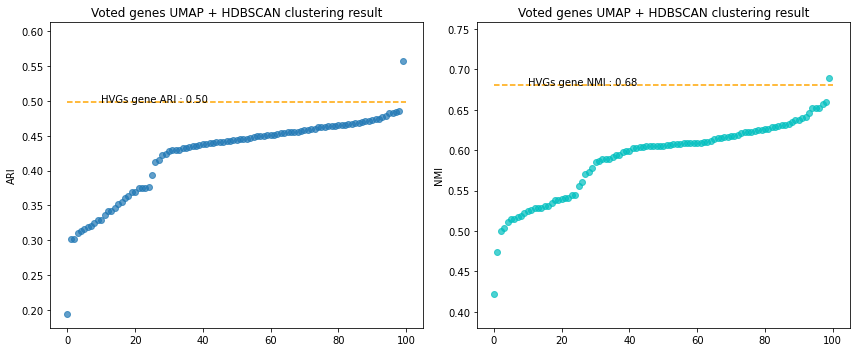

In [8]:
fig,axs = plt.subplots(1,2,figsize = (12,5))
axes = axs.ravel()
condition = 'virus'

for m_idx,metric in enumerate(['ARI','NMI']) :
    ax = axes[m_idx]
    if condition == 'patient':
        metric_result = patient_df[metric].values
    else :
        metric_result = virus_df[metric].values

    voted_res = metric_result[-1]
    random_res = sorted(metric_result[:100])
    print("%d random sample clustering result outperform the clustering result from voted genes" % sum(random_res > voted_res))
    x = np.arange(100)
    if metric == 'NMI' :
        ax.scatter(x,random_res,alpha=0.7,c='c')
    else :
        ax.scatter(x,random_res,alpha=0.7)
    ax.hlines(y=voted_res,xmin=0,xmax=100,linestyles='--',colors='orange')
    ax.set_ylabel(metric)
    ax.set_title("Voted genes UMAP + HDBSCAN clustering result")
    ax.set_ylim([random_res[0] * 0.9,max(metric_result)*1.1])
    ax.text(10,voted_res,"HVGs gene %s : %0.2f" % (metric,voted_res))
plt.tight_layout()
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/voted_genes_random_sampling_cluster_result_%s.pdf" % condition,
    format='pdf',dpi=300,bbox_inches='tight')